# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. The model we want to use is:

\begin{align}
\mathbf{z} & \sim \text{MRF} \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
\sigma_2 & \sim \text{Half-Cauchy}(0, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right), \sigma^2\right) \\
\end{align}


We start with some simple models, see them in the other notebooks.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as tt

In [3]:
from sklearn import preprocessing
from pymc3 import  model_to_graphviz

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

Since the MRF is particularly hard to estimate, we make use of a simpler representation first.

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(1, 1) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau_g^2 & \sim \text{Gamma}(1, 1) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau_g^2) \\
\tau_b^2 & \sim \text{Gamma}(1, 1) \\
\beta_{cg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau_b^2) \\
l_{cgs} & \sim \text{Lognormal}(1, 1) \\
x_{cgs} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vgs} \cdot \exp \left( \beta_{cg} \right) \right) \\
\end{align}

## Data

In [ ]:
le = preprocessing.LabelEncoder()

In [11]:
file_path = os.path.join('../', 'data_raw', 'read_counts-normalized.tsv')

In [92]:
sirna_data = pd.read_csv(file_path, sep="\t")

In [93]:
sirna_data = (sirna_data[["Gene", "sgRNA", "LSLCas9_134", "LSLCas9_136"]]
    .query("Gene != 'Control'")
    .rename(index=str, columns={"LSLCas9_134": "r1", "LSLCas9_136": "r2"})
    .melt(id_vars=['Gene', 'sgRNA'], value_vars=['r1', 'r2'],
          var_name='replicate', value_name='counts')
    .sort_values(['Gene', 'sgRNA', 'replicate'])
)

In [96]:
sirna_data["sgRNA"] = le.fit_transform(sirna_data["sgRNA"].values)

In [97]:
sirna_data[:5]

,Gene,sgRNA,replicate,counts
0,ACSM3,0,r1,8987.015957
900,ACSM3,0,r2,9300.411518
1,ACSM3,1,r1,15742.897879
901,ACSM3,1,r2,15869.905865
2,ACSM3,2,r1,17348.226026


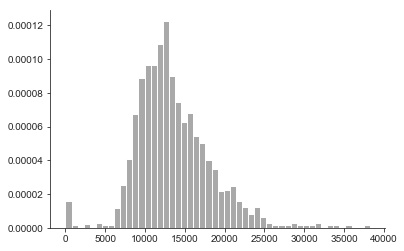

In [29]:
plt.hist(sirna_data[["counts"]].values, color="darkgrey", bins=50, density=True);
plt.show()

In [109]:
sirna_data.query("counts < 200")

,Gene,sgRNA,replicate,counts
78,B4GALT6,78,r1,1.007739
978,B4GALT6,78,r2,1.092367
357,FMO3,357,r1,1.007739
1257,FMO3,357,r2,1.092367
555,MNAT1,555,r1,1.007739
1455,MNAT1,555,r2,1.092367
687,PRPH2,687,r1,1.007739
1587,PRPH2,687,r2,1.092367
777,SEL1L2,777,r1,12.092867
1677,SEL1L2,777,r2,30.586272


Since it is always _both_ replicates that have a low read count, it is safe to assume that these are no batch effects.

## Inference

In [131]:
sirna_data[:20]

,Gene,sgRNA,replicate,counts
0,ACSM3,0,r1,8987.015957
900,ACSM3,0,r2,9300.411518
1,ACSM3,1,r1,15742.897879
901,ACSM3,1,r2,15869.905865
2,ACSM3,2,r1,17348.226026
902,ACSM3,2,r2,17373.002676
3,ACSM3,3,r1,9330.654939
903,ACSM3,3,r2,9374.692465
4,ACSM3,4,r1,8995.077869
904,ACSM3,4,r2,9365.953530


In [126]:
sirna_data.shape

(1800, 4)

In [102]:
gene_idx = le.fit_transform(sirna_data["Gene"].values)
len_genes = len(np.unique(gene_idx))

In [104]:
len_genes

90

In [103]:
gene_idx

array([ 0,  0,  0, ..., 89, 89, 89])

In [105]:
len_conditions = 1

In [111]:
len_sirnas = len(np.unique(sirna_data["sgRNA"].values))
len_sirnas

900

In [133]:
len_sirnas_per_gene = int(len_sirnas / len_genes)
len_sirnas_per_gene

10

In [112]:
len_replicates = len(np.unique(sirna_data["replicate"].values))
len_replicates

2

In [127]:
beta_idx = np.repeat(range(len_genes), len_conditions)
beta_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89])

In [136]:
beta_data_idx = np.repeat(beta_idx, len_replicates * len_sirnas_per_gene)
beta_data_idx[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [141]:
l_idx = np.repeat(range(len_genes * len_conditions * len_sirnas_per_gene), len_replicates)
l_idx

array([  0,   0,   1, ..., 898, 899, 899])

In [143]:
counts = sirna_data[["counts"]].values
counts[:10]

array([[ 8987.01595723],
       [ 9300.41151812],
       [15742.89787888],
       [15869.90586508],
       [17348.22602643],
       [17373.00267609],
       [ 9330.65493922],
       [ 9374.69246518],
       [ 8995.07786883],
       [ 9365.95353023]])

In [ ]:
with pm.Model() as model:
    p = pm.Dirichlet('p', a=np.array([1., 1.]), shape=2)
    p_min_pot = pm.Potential('p_pot', tt.switch(tt.min(p) < .05, -np.inf, 0))
    category = pm.Categorical('category', p=p, shape=len_genes)
    
    tau_g = pm.Gamma('tau_g', 1., 1., shape=1)
    mean_g = pm.Normal('mu_g', mu=np.array([0, 0]), sd=.5, shape=2)
    mean_order_pot = pm.Potential('mop', tt.switch(mean_g[1] - mean_g[0] < 0, -np.inf, 0))    
    gamma = pm.Normal('gamma', mean_g[category], tau_g, shape=len_genes)
    
    tau_b = pm.Gamma('tau_b', 1., 1., shape=1)
    beta = pm.Normal('beta', gamma[beta_idx], tau_b, shape=len(beta_idx))
    l = pm.Lognormal('l', 0, .25, shape = len_sirnas)
    
    x = pm.Poisson(
        'x', 
        mu = np.exp(beta[beta_data_idx]) * l[l_idx] ,
        observed=counts)

In [ ]:
model_to_gr